In [1]:
# DS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas.tools import sjoin

import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

from my_utils import *

In [2]:
print(VERSION)

v3.0


## load data

In [3]:
gdf_zoning = read_csv_to_gdf(f"result/gdf_zoning_{VERSION}.csv").to_crs("epsg:2263")

In [4]:
gdf_poi = gpd.GeoDataFrame(pd.read_pickle(f"result/gdf_poi_{VERSION}.pkl"),crs="epsg:4326",geometry="geometry").to_crs("epsg:2263")

##  generate sequences

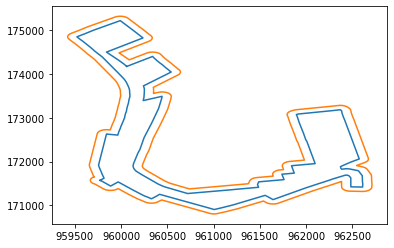

In [5]:
xb,yb = gdf_zoning.loc[1,"geometry"].buffer(100).exterior.xy
x,y = gdf_zoning.loc[1,"geometry"].exterior.xy
plt.plot(x,y)
plt.plot(xb,yb)

In [6]:
# buffer zoning
from shapely.geometry import Polygon

gdf_zoning_b = gdf_zoning
gdf_zoning_b["geometry"] =  gdf_zoning_b["geometry"].apply(lambda x:Polygon(x.buffer(100).exterior))

### Option 1. Distance Greedy 

In [7]:
# # either-or
# sequences = get_sequences_by_distancegreedy(gdf_zoning_b, gdf_poi)
sequences = np.load(f"result/Sequences_greedy_{VERSION}.npy",allow_pickle=True).item()

<AxesSubplot:>

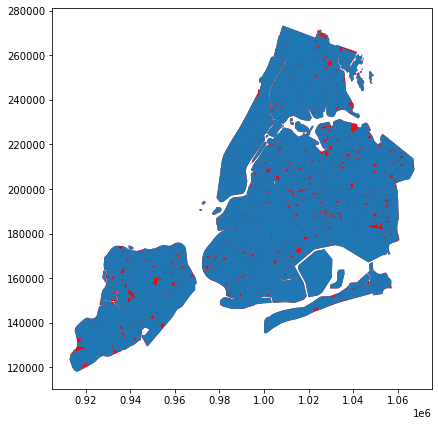

In [8]:
# plot areas without poi
df_join = sjoin(gdf_poi, gdf_zoning_b, how="inner",op="within")

ax = gdf_zoning_b.plot(figsize=(7,7),facecolor="r")
gdf_zoning_b.loc[list(df_join.index_right.unique())].plot(ax=ax)

In [9]:
np.save(f"result/Sequences_greedy_{VERSION}.npy", sequences)

In [10]:
len(sequences.keys()),len(gdf_zoning_b)

(3824, 5470)

## Train

In [11]:
sequences = np.load(f"result/Sequences_greedy_{VERSION}.npy",allow_pickle=True).item()

In [12]:
corpus = [TaggedDocument([str(x) for x in words], [f'd{idx}'])for idx, words in sequences.items()]

In [13]:
corpus[2]

TaggedDocument(words=['0702', '0702', '0608', '0702'], tags=['d2323'])

In [14]:
model = gensim.models.doc2vec.Doc2Vec(dm = 1, # PV-DM
                                      vector_size = VEC_DIM,  # Dimensionality 
                                      dm_mean = 1, # use the mean of the context word vectors.
                                      window =5,
                                      dbow_words = 1 ,
                                      min_count = 0,  #  Ignores all words with total frequency lower than this.
                                      epochs=50)

model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [15]:
# model.save("model/doc2vec_model")

* Load the trained model rather than create a new model

In [16]:
model = Doc2Vec.load("model/doc2vec_model")

## Export

In [17]:
df_zonevec = pd.DataFrame.from_dict({'id':sequences.keys()})

i = 1
for v in model.docvecs.vectors_docs.T:
    df_zonevec[f"ZoneVec_{i}"] = v
    i += 1

df_zonevec['id'] = df_zonevec.id.astype('int')
df_zonevec = df_zonevec.set_index("id")

In [18]:
# df_zonevec.to_csv(f"result/df_zonevec_{VERSION}.csv")

In [19]:
my_dict = dict({})
for idx, key in enumerate(model.wv.vocab):
    my_dict[key] = model.wv[key]
    
df_poivec = pd.DataFrame.from_dict(my_dict).T.reset_index().rename(columns={"index":"code"})
df_poivec.columns = ["code"] + [f"POIVec_{i+1}" for i in range(VEC_DIM)]

In [20]:
# df_poivec.to_csv(f"result/df_poivec_{VERSION}.csv",index=False)